In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json
import time

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch

import pathlib

import config as cfg

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

import copy

from save_results import save_results_smart, list_saved_configs
from evaluation.nlg_metrics import Metrics

/home/nad/studies/Transformer-Image-Captioning-IIW/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/nad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nad/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/nad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
importlib.reload(cfg)
torch.cuda.empty_cache()

## Define Parameters

In [3]:
config = cfg.make_config()

In [4]:
batch_size_train = config["BATCH_SIZE_TRAIN"]
batch_size_test = config["BATCH_SIZE_TEST"]

H = config["IMG_HEIGHT"]
W = config["IMG_WIDTH"]
P = config["PATCH_SIZE"]
D_IMG = config["IMG_EMBEDDING_DIM"]

# The data will get truncated/padded to this length AFTER tokenization
L = config["MAX_TEXT_SEQUENCE_LENGTH"]
D_TEXT = config["TEXT_EMBEDDING_DIM"]
DROPOUT_DEC = config["DECODER_DROPOUT_PROB"]
RANDOM_SEED = config["RANDOM_SEED"]

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(42)

## Build Dataset

In [6]:
data_loader = DatasetLoader(dataset_type=config["DATASET"],
                            img_height=H,
                            img_width=W,
                            batch_size_train=batch_size_train, 
                            batch_size_test=batch_size_test,
                            split_ratio=config["SPLIT_RATIO"],
                            shuffle_test=True,
                            seed=RANDOM_SEED)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

Loading COCO dataset...


## Inspect Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9951199].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.1171243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482

Number of training samples: 32403
Number of test samples: 8101
torch.Size([16, 3, 224, 224])
Caption: a woman and a kid playing with some wii motes
torch.Size([16, 3, 224, 224])
Caption: A crowd of people laying on a beach next to surfboards.
torch.Size([16, 3, 224, 224])
Caption: Young boys in suits and ties posing for photo.
torch.Size([16, 3, 224, 224])
Caption: A child holds a plastic object while another person cuts it.
torch.Size([16, 3, 224, 224])
Caption: A view of a street at night shows a yellow fire hydrant.
torch.Size([16, 3, 224, 224])
Caption: Kites flying in cloudy sky over the ocean.
torch.Size([16, 3, 224, 224])
Caption: a couple of sheep graze on some grass
torch.Size([16, 3, 224, 224])
Caption: A person is flying a biplane in the sky.
torch.Size([16, 3, 224, 224])
Caption: A toilet that is covered in some filth, and some filth on the ground.
torch.Size([16, 3, 224, 224])
Caption: Fans observing a baseball game in process.
torch.Size([16, 3, 224, 224])
Caption: A bath

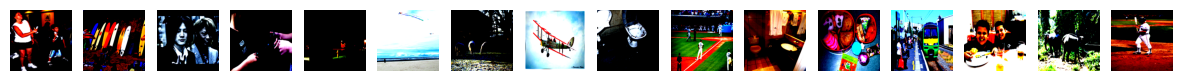

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].

torch.Size([16, 3, 224, 224])
Caption: A large white clock tower filled with light.
torch.Size([16, 3, 224, 224])
Caption: a number of items laying on a surface near one another
torch.Size([16, 3, 224, 224])
Caption: Stop signs on a school bus are opening up.
torch.Size([16, 3, 224, 224])
Caption: Some taxi cabs parked along the side of a road.
torch.Size([16, 3, 224, 224])
Caption: A group of lawn chairs sitting on top of a beach.
torch.Size([16, 3, 224, 224])
Caption: People sitting on benches in the park, and traffic in the street
torch.Size([16, 3, 224, 224])
Caption: A display of broccoli, rice patties, bread, and carrots.
torch.Size([16, 3, 224, 224])
Caption: A street area with a building and cars.
torch.Size([16, 3, 224, 224])
Caption: A man is talking to a woman behind a podium.
torch.Size([16, 3, 224, 224])
Caption: A black and white dog laying on a blue chair next to bags of presents.
torch.Size([16, 3, 224, 224])
Caption: A living room with hard wood floors and a book shelf

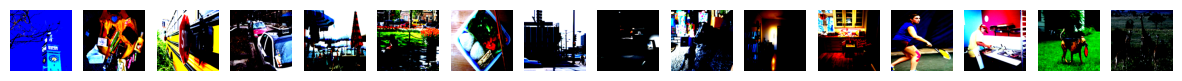

In [7]:
# dataset stats
print(f"Number of training samples: {len(train_dataloader.dataset)}")
print(f"Number of test samples: {len(test_dataloader.dataset)}")

# plot some samples from the dataset
data_iter = iter(test_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_test, figsize=(15, 5))
for i in range(batch_size_test):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

data_iter = iter(train_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_train, figsize=(15, 5))
for i in range(batch_size_train):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

## Initialize Tokenizer

In [8]:
special_tokens = [cfg.SpecialTokens.PAD, cfg.SpecialTokens.BOS, cfg.SpecialTokens.EOS]
if config["TOKENIZER_TYPE"] == cfg.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config["TOKENIZER_TYPE"] == cfg.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=config["TOKENIZER_DATA_PATH"], filename_prefix=config["TOKENIZER_FILENAME_PREFIX"])
    
pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer vocab size: {vocab_size}, Pad token ID: {pad_idx}")

Tokenizer vocab size: 8577, Pad token ID: 0


## Initialize Metrics

In [9]:
nlg_metrics = Metrics()

## Configure Model

In [10]:
transformer = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)

Initialized CNN + CPTR Encoder


## Training code

### Early Stopping and Checkpoint Loading

In [11]:
class EarlyStopping:
    def __init__(self, patience, delta, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.best_bleu = None
        self.best_meteor = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_model_state = None
        self.best_bleu_state = None
        self.best_meteor_state = None
    
    def check_early_stop(self, val_loss, val_bleu, val_meteor, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                if self.verbose:
                    print("Stopping early as no improvement has been observed.")
        if self.best_bleu is None or val_bleu > self.best_bleu + self.delta:
            self.best_bleu = val_bleu
            self.best_bleu_state = copy.deepcopy(model.state_dict())
        if self.best_meteor is None or val_meteor > self.best_meteor + self.delta:
            self.best_meteor = val_meteor
            self.best_meteor_state = copy.deepcopy(model.state_dict())

### Train and Evaluate Steps

In [12]:
def train_step(model: torch.nn.Module,
               config,
               dataloader: torch.utils.data.DataLoader,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch in dataloader:
        images = batch["pixel_values"].to(device)
        texts = batch["description"]

        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids']
        tokens = tokens.to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        attention_mask = get_causal_mask(T, device=device)
        padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)

        logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients to a max norm of 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def train_step_accumulate(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               config,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               accumulation_steps: int,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    accumulation_steps: Number of steps to accumulate gradients before updating the model.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    model.train()
    train_loss, train_acc = 0, 0
    
    # Reset gradients at the start
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
        images = batch["pixel_values"].to(device)
        texts = batch["description"]
        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids'].to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        
        logits, loss = model(
            images=images, 
            text_tokens=decoder_inputs, 
            attn_mask=get_causal_mask(T, device), 
            pad_mask=get_padding_mask(decoder_inputs, pad_idx, device), 
            targets=targets
        )

        # 3. Normalize loss to account for accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # 4. Optimizer Step (only every 'accumulation_steps')
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad() # Clear for next set

        train_loss += (loss.item() * accumulation_steps)

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def test_step(model: torch.nn.Module,
              config,
              dataloader: torch.utils.data.DataLoader,
              tokenizer,
              pad_idx: int,
              device: torch.device, 
              epoch=None, 
              calculate_metrics=False, 
              metrics_calculator=None,
              verbose=False) -> Tuple[float, float, float, Dict[str, float]]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    model.eval()

    test_loss, test_acc = 0, 0
    all_refs = []
    all_hypos = []
    # Turn on inference context manager
    with torch.inference_mode():
        for i, batch in enumerate(dataloader):
          images = batch["pixel_values"].to(device)
          texts = batch["description"]

          outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
          tokens = outputs['input_ids']
          tokens = tokens.to(device)
          tokens = tokens.to(device)

          targets = tokens[:, 1:]
          decoder_inputs = tokens[:, :-1]
          T = decoder_inputs.size(1)
          attention_mask = get_causal_mask(T, device=device)
          padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)
        
          logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

          test_loss += loss.item()

          preds = logits.argmax(dim=-1)
          pad_idx = tokenizer.get_padding_token_id()
          non_pad = targets != pad_idx
          acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
          test_acc += acc.item()
          
          # calculate only last 10 batches to save time
          if calculate_metrics and metrics_calculator and (i >= len(dataloader) - 10):
                decoded_preds = []
                for img in images:
                    generated_tokens = model.generate(img.unsqueeze(0), 
                        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                        max_len=L,
                        device=device)
                    if not isinstance(generated_tokens, torch.Tensor):
                        generated_tokens = torch.tensor(generated_tokens)

                    # NLTK metrics expect lists of words: ["a", "squirrel", "on", "a", "fence"]
                    generated_tokens = tokenizer.decode(generated_tokens) # returns ["sentence 1", "sentence 2", ...] with special tokens
                    # Remove special tokens
                    generated_tokens = tokenizer.strip(generated_tokens)
                    decoded_preds.append(generated_tokens)
                decoded_targets = texts # Ground Truth

                for p, t in zip(decoded_preds, decoded_targets):
                    all_hypos.append(p.split())
                    all_refs.append([t.split()])
          
          if verbose:
            # print produced tokens for debugging
            if epoch is not None and config["NUM_EPOCHS"] - epoch <= 1:  # print only for last 2 epochs
              decoded_preds = tokenizer.decode_batched(preds)
              decoded_targets = tokenizer.decode_batched(targets)
              for dp, dt in zip(decoded_preds, decoded_targets):
                  print(f"Predicted: {dp} | Target: {dt}")

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_perplexity = torch.exp(torch.tensor(test_loss)).item()
    test_acc = test_acc / len(dataloader)

    metrics_results = {}
    if calculate_metrics and metrics_calculator:
        metrics_results = metrics_calculator.calculate(all_refs, all_hypos, train=True)

    return test_loss, test_perplexity, test_acc, metrics_results

def train(model: torch.nn.Module,
          config,
          tokenizer, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          epochs: int,
          device: torch.device,
          return_best_model: bool,
          return_best_bleu: bool,
          return_best_meteor: bool,
          early_stop_patience: int,
          early_stop_delta: float,
          metrics_calculator = None,
          calculate_metrics=False) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    return_best_model: Whether to return the model state with the best performance.
    return_best_bleu: Whether to return the model state with the best BLEU score.

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_perplexity: [...],
              train_acc: [...],
              test_loss: [...],
              test_perplexity: [...],
              test_acc: [...]}
              test_bleu: [...],
              test_meteor: [...],
    """
    results = {"train_loss": [],
               "train_perplexity": [],
               "train_acc": [],
               "test_loss": [],
               "test_perplexity": [],
               "test_acc": [],
               "test_bleu": [],
               "test_meteor": [],
    }
    
    model.to(device)
    
    pad_idx = tokenizer.get_padding_token_id()
    early_stopping = EarlyStopping(patience=early_stop_patience, delta=early_stop_delta, verbose=True)

    for epoch in tqdm(range(epochs)):
        if config["USE_ACCUMULATED_GRADIENTS"]:
            train_loss, train_perplexity, train_acc = train_step_accumulate(model=model,
                                              config=config,
                                              dataloader=train_dataloader,
                                              tokenizer=tokenizer,
                                              pad_idx=pad_idx,
                                              optimizer=optimizer,
                                              scheduler=scheduler,
                                              accumulation_steps=config["ACCUMULATION_STEPS"],
                                              device=device,
                                              epoch=epoch)
        else:
          train_loss, train_perplexity, train_acc = train_step(model=model,
                                            config=config,
                                            dataloader=train_dataloader,
                                            tokenizer=tokenizer,
                                            pad_idx=pad_idx,
                                            optimizer=optimizer,
                                            scheduler=scheduler,
                                            device=device,
                                            epoch=epoch)
        test_loss, test_perplexity, test_acc, test_metrics = test_step(model=model,
                                                         config=config,
                                                         dataloader=test_dataloader,
                                                         tokenizer=tokenizer,
                                                         pad_idx=pad_idx,
                                                         device=device,
                                                         epoch=epoch,
                                                         calculate_metrics=True,
                                                         metrics_calculator=metrics_calculator)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_perplexity: {train_perplexity:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_perplexity: {test_perplexity:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        if calculate_metrics:
            print("NLG metrics:")
            for metric_name, metric_value in test_metrics.items():
                print(f"  {metric_name}: {metric_value:.4f}")

        results["train_loss"].append(train_loss)
        results["train_perplexity"].append(train_perplexity)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_perplexity"].append(test_perplexity)
        results["test_acc"].append(test_acc)
        if calculate_metrics:
            results["test_bleu"].append(test_metrics.get("bleu4", 0.0))
            results["test_meteor"].append(test_metrics.get("meteor", 0.0))

        early_stopping.check_early_stop(val_loss=test_loss, val_bleu=test_metrics.get("bleu4", 0.0), val_meteor=test_metrics.get("meteor", 0.0), model=model)
        if early_stopping.stop_training:
            if return_best_model:
                model.load_state_dict(early_stopping.best_model_state)
            elif return_best_bleu:
                model.load_state_dict(early_stopping.best_bleu_state)
            elif return_best_meteor:
                model.load_state_dict(early_stopping.best_meteor_state)
            break
    
    return results, early_stopping.best_model_state, early_stopping.best_bleu_state, early_stopping.best_meteor_state

### Encoder Training Parameters Tuning

In [13]:
# freeze/unfreeze encoder weights
def config_encoder_params(model, requires_grad: bool):
    if config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_RESNET50:
        if requires_grad == True:
            for layer in model.encoder.backbone[-2:]:  # unfreeze last 2 residual blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.parameters():
                param.requires_grad = False
                
    elif config["ENCODER_ARCH"] == cfg.EncoderArch.VIT_STYLE_BASE or config["ENCODER_ARCH"] == cfg.EncoderArch.VIT_STYLE_LARGE:
        if requires_grad == True:
            for layer in model.encoder.vit.encoder.layer[-3:]:  # unfreeze last 3 transformer blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.parameters():
                param.requires_grad = False
                
    elif config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_CPTR_STYLE:
        if requires_grad == True:
            for layer in model.encoder.patcher.backbone[-2:]:  # unfreeze last 2 residual blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.patcher.parameters():
                param.requires_grad = False
                
    else:
        for param in model.encoder.parameters():
            param.requires_grad = requires_grad

In [14]:
if config["USE_ACCUMULATED_GRADIENTS"]:
    effective_steps_per_epoch = len(train_dataloader) // config["ACCUMULATION_STEPS"]
    # Account for the possible partial batch at the end
    if len(train_dataloader) % config["ACCUMULATION_STEPS"] != 0:
        effective_steps_per_epoch += 1
else:
    effective_steps_per_epoch = len(train_dataloader)

## First Training Stage (Frozen Encoder)

In [15]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    config_encoder_params(transformer, requires_grad=False)
    
    optimizer = torch.optim.AdamW(
        [p for p in transformer.parameters() if p.requires_grad],
        lr=config["LR"],
        weight_decay=0.01
    )

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["LR"], 
        steps_per_epoch=effective_steps_per_epoch, 
        epochs=config["NUM_FREEZE_EPOCHS"],
        pct_start=0.05 # 5% of time spent warming up
    )

In [16]:
# Check which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
encoder.img_pos_embedding.pos_embedding: torch.Size([1, 49, 2048])
encoder.encoder_blocks.0.MHSA.in_proj_weight: torch.Size([6144, 2048])
encoder.encoder_blocks.0.MHSA.out_proj.weight: torch.Size([2048, 2048])
encoder.encoder_blocks.0.layer_norm_1.weight: torch.Size([2048])
encoder.encoder_blocks.0.layer_norm_1.bias: torch.Size([2048])
encoder.encoder_blocks.0.FFN.0.weight: torch.Size([8192, 2048])
encoder.encoder_blocks.0.FFN.3.weight: torch.Size([2048, 8192])
encoder.encoder_blocks.0.layer_norm_2.weight: torch.Size([2048])
encoder.encoder_blocks.0.layer_norm_2.bias: torch.Size([2048])
encoder.encoder_blocks.1.MHSA.in_proj_weight: torch.Size([6144, 2048])
encoder.encoder_blocks.1.MHSA.out_proj.weight: torch.Size([2048, 2048])
encoder.encoder_blocks.1.layer_norm_1.weight: torch.Size([2048])
encoder.encoder_blocks.1.layer_norm_1.bias: torch.Size([2048])
encoder.encoder_blocks.1.FFN.0.weight: torch.Size([8192, 2048])
encoder.encoder_blocks.1.FFN.3.weight: 

In [17]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    # Train the model for freezing phase
    results, best_early_test_state, best_early_bleu_state, best_early_meteor_state = train(model=transformer,
                    config=config,
                    tokenizer=tokenizer,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    epochs=config["NUM_FREEZE_EPOCHS"],
                    device=device,
                    return_best_model=False,
                    return_best_bleu=False,
                    return_best_meteor=True,
                    calculate_metrics=True,
                    metrics_calculator=nlg_metrics,
                    early_stop_patience=config["EARLY_STOPPING_PATIENCE"],
                    early_stop_delta=config["EARLY_STOPPING_DELTA"])
    print('Completed freezing phase.')

  0%|          | 0/5 [01:31<?, ?it/s]


KeyboardInterrupt: 

## First Stage Training Evaluation

In [ ]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    device = "cpu"
    transformer.to(device)
    transformer_best_state = CPTR(num_patches=config["NUM_PATCHES"],
                       encoder_arch=config["ENCODER_ARCH"],
                       encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                       use_embedding_projection=config["USE_PROJECTION_LAYER"],
                       img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                       img_emb_dim=config["IMG_EMBEDDING_DIM"],
                       patch_size=config["PATCH_SIZE"],
                       text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                       d_model=config["EMBEDDING_DIM"],
                       max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                       vocab_size=vocab_size,
                       pad_idx=pad_idx,
                       channels=config["NUM_INPUT_CHANNELS"],
                       num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                       num_encoder_heads=config["ENCODER_NUM_HEADS"],
                       encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                       encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                       num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                       num_decoder_heads=config["DECODER_NUM_HEADS"],
                       decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                       decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                       bias=config["USE_BIAS"],
                       use_weight_tying=config["USE_WEIGHT_TYING"],
                       sublayer_dropout=config["SUBLAYER_DROPOUT"],
                       verbose=False).to(device)
    transformer_best_state.load_state_dict(best_early_test_state)

    transformer_best_bleu = CPTR(num_patches=config["NUM_PATCHES"],
                       encoder_arch=config["ENCODER_ARCH"],
                       encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                       use_embedding_projection=config["USE_PROJECTION_LAYER"],
                       img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                       img_emb_dim=config["IMG_EMBEDDING_DIM"],
                       patch_size=config["PATCH_SIZE"],
                       text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                       d_model=config["EMBEDDING_DIM"],
                       max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                       vocab_size=vocab_size,
                       pad_idx=pad_idx,
                       channels=config["NUM_INPUT_CHANNELS"],
                       num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                       num_encoder_heads=config["ENCODER_NUM_HEADS"],
                       encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                       encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                       num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                       num_decoder_heads=config["DECODER_NUM_HEADS"],
                       decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                       decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                       bias=config["USE_BIAS"],
                       use_weight_tying=config["USE_WEIGHT_TYING"],
                       sublayer_dropout=config["SUBLAYER_DROPOUT"],
                       verbose=False).to(device)
    transformer_best_bleu.load_state_dict(best_early_bleu_state)

    transformer_best_meteor = CPTR(num_patches=config["NUM_PATCHES"],
                       encoder_arch=config["ENCODER_ARCH"],
                       encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                       use_embedding_projection=config["USE_PROJECTION_LAYER"],
                       img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                       img_emb_dim=config["IMG_EMBEDDING_DIM"],
                       patch_size=config["PATCH_SIZE"],
                       text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                       d_model=config["EMBEDDING_DIM"],
                       max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                       vocab_size=vocab_size,
                       pad_idx=pad_idx,
                       channels=config["NUM_INPUT_CHANNELS"],
                       num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                       num_encoder_heads=config["ENCODER_NUM_HEADS"],
                       encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                       encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                       num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                       num_decoder_heads=config["DECODER_NUM_HEADS"],
                       decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                       decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                       bias=config["USE_BIAS"],
                       use_weight_tying=config["USE_WEIGHT_TYING"],
                       sublayer_dropout=config["SUBLAYER_DROPOUT"],
                       verbose=False).to(device)
    transformer_best_meteor.load_state_dict(best_early_meteor_state)

In [ ]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img):
    return img * IMAGENET_STD + IMAGENET_MEAN

In [ ]:
if config["NUM_FREEZE_EPOCHS"] > 0:
        transformer.eval()
        transformer_best_state.eval()
        transformer_best_bleu.eval()
        transformer_best_meteor.eval()
        
        batch = next(iter(train_dataloader))
        image = batch["pixel_values"][0].unsqueeze(0).to(device)
        print('Caption GT: ', batch["description"][0])
        print('Input image shape:', image.shape)
        # plot input image
        img = image[0].cpu()
        img = denormalize(img)
        img = img.clamp(0, 1)
        img = img.permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        tokens = transformer.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=False)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        # print('Generated token ids:', tokens)
        # print(tokens.shape)
        decoded_caption = tokenizer.decode(tokens)
        print('(Longest trained model) Generated caption:', decoded_caption)
        
        tokens = transformer_best_state.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=False)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best test loss model) Generated caption:', decoded_caption)
        
        tokens = transformer_best_bleu.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=False)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best BLEU model) Generated caption:', decoded_caption)
        
        tokens = transformer_best_meteor.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=False)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best METEOR model) Generated caption:', decoded_caption)

In [ ]:
if config["NUM_FREEZE_EPOCHS"] > 0:
        batch = next(iter(test_dataloader))
        image = batch["pixel_values"][0].unsqueeze(0).to(device)
        print('Caption GT: ', batch["description"][0])
        print('Input image shape:', image.shape)
        # plot input image
        img = image[0].cpu()
        img = denormalize(img)
        img = img.clamp(0, 1)
        img = img.permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tokens = transformer.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=True)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        # print('Generated token ids:', tokens)
        # print(tokens.shape)
        decoded_caption = tokenizer.decode(tokens)
        print('(Longest trained model) Generated caption:', decoded_caption)

        tokens = transformer_best_state.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=True)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best test loss model) Generated caption:', decoded_caption)

        tokens = transformer_best_bleu.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=True)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best BLEU model) Generated caption:', decoded_caption)

        tokens = transformer_best_meteor.generate(image, 
                bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
                eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
                max_len=L,
                device=device,
                used_tokens_penalty=True)
        if not isinstance(tokens, torch.Tensor):
                tokens = torch.tensor(tokens)
        decoded_caption = tokenizer.decode(tokens)
        print('(Best METEOR model) Generated caption:', decoded_caption)

### Intermediate Results Bookkeeping

In [ ]:
if config["NUM_FREEZE_EPOCHS"] > 0:    
    # export training results to experiments directory
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    dir = 'experiments/' + 'config_{}'.format(timestamp)
    os.makedirs(dir, exist_ok=True)
    results_path = os.path.join(dir, 'training_results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f)
    # export config to results directory
    config_path = os.path.join(dir, 'config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f)

    # export model weights
    model_path = os.path.join(dir, f'cptr_model.pth')
    torch.save(transformer.state_dict(), model_path)
    best_loss_model_path = os.path.join(dir, f'cptr_best_loss_model.pth')
    torch.save(best_early_test_state, best_loss_model_path)
    best_bleu_model_path = os.path.join(dir, f'cptr_best_bleu_model.pth')
    torch.save(best_early_bleu_state, best_bleu_model_path)
    best_meteor_model_path = os.path.join(dir, f'cptr_best_meteor_model.pth')
    torch.save(best_early_meteor_state, best_meteor_model_path)

## Second Training Stage (Unfrozen Encoder)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
config_encoder_params(transformer, requires_grad=True)

if config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_RESNET50:
    optimizer = torch.optim.AdamW(
        [
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder.backbone" not in n],
                'lr': config["LR"]
            },
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder.backbone" in n],
                'lr': config["LR"] * 0.1
            }
        ],
        weight_decay=config["WEIGHT_DECAY"]
    )
elif config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_CPTR_STYLE:
    optimizer = torch.optim.AdamW(
        [
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder.patcher.backbone" not in n],
                'lr': config["LR"]
            },
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder.patcher.backbone" in n],
                'lr': config["LR"] * 0.1
            }
        ],
        weight_decay=config["WEIGHT_DECAY"]
    )
else:
    optimizer = torch.optim.AdamW(
        [
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder" not in n],
                'lr': config["LR"]
            },
            {
                'params': [p for n, p in transformer.named_parameters() if "encoder" in n],
                'lr': config["LR"] * 0.1
            }
        ],
        weight_decay=config["WEIGHT_DECAY"]
    )

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#    optimizer,
#    T_max=config["NUM_EPOCHS"],
#    eta_min=5e-7
#)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["LR"], 
        steps_per_epoch=effective_steps_per_epoch, 
        epochs=config["NUM_EPOCHS"],
        pct_start=0.01 # 1% of time spent warming up
    )

In [ ]:
# Recheck which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
encoder.patcher.backbone.0.weight: torch.Size([64, 3, 7, 7])
encoder.patcher.backbone.1.weight: torch.Size([64])
encoder.patcher.backbone.1.bias: torch.Size([64])
encoder.patcher.backbone.4.0.conv1.weight: torch.Size([64, 64, 1, 1])
encoder.patcher.backbone.4.0.bn1.weight: torch.Size([64])
encoder.patcher.backbone.4.0.bn1.bias: torch.Size([64])
encoder.patcher.backbone.4.0.conv2.weight: torch.Size([64, 64, 3, 3])
encoder.patcher.backbone.4.0.bn2.weight: torch.Size([64])
encoder.patcher.backbone.4.0.bn2.bias: torch.Size([64])
encoder.patcher.backbone.4.0.conv3.weight: torch.Size([256, 64, 1, 1])
encoder.patcher.backbone.4.0.bn3.weight: torch.Size([256])
encoder.patcher.backbone.4.0.bn3.bias: torch.Size([256])
encoder.patcher.backbone.4.0.downsample.0.weight: torch.Size([256, 64, 1, 1])
encoder.patcher.backbone.4.0.downsample.1.weight: torch.Size([256])
encoder.patcher.backbone.4.0.downsample.1.bias: torch.Size([256])
encoder.patcher.backbone.4.1.conv1.wei

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Train the model for the rest of the epochs and save the training results to a dictionary
results, best_model_test_state, best_model_bleu_state, best_model_meteor_state = train(model=transformer,
                config=config,
                tokenizer=tokenizer,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                epochs=config["NUM_EPOCHS"],
                device=device,
                return_best_model=False,
                return_best_bleu=False,
                return_best_meteor=False,
                calculate_metrics=True,
                metrics_calculator=nlg_metrics,
                early_stop_patience=int(config["NUM_EPOCHS"]*0.8),
                early_stop_delta=config["EARLY_STOPPING_DELTA"])
print('Completed training.')

  0%|          | 0/15 [00:43<?, ?it/s]


KeyboardInterrupt: 

## Export Trained Model

In [ ]:
success, message, target_folder_name = save_results_smart(model=transformer, results=results, current_config=config)

if success:
    print("✓ Results saved successfully!")
    print(message)
else:
    print("✗ Results not saved:")
    print(message)

Current test loss: 2.6109862132420436
Searching for matching configuration folder...
  - Checking folder: config_20260121-041202
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: config_20260122-140205
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: config_20260122-140134
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: plots_norm
    -> No config file found, skipping.
  - Checking folder: config_20260127-043414
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: config_20260121-200819
    Comparing DATASET: 'coco' vs 'flickr'
    -> Mismatch found in DATASET
  - Checking folder: config_20260128-092948
    Comparing DATASET: 'coco' vs 'coco'
    Comparing ENCODER_ARCH: 'resnet50' vs 'google/vit-base-patch16-224-in21k'
    -> Mismatch found in ENCODER_ARCH
✓ Results saved successfully!
Created new config 

## Evaluate Caption Generation

In [ ]:
device = "cpu"
transformer.to(device)
transformer_best_state = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer_best_state.load_state_dict(best_model_test_state)

transformer_best_bleu = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer_best_bleu.load_state_dict(best_model_bleu_state)

transformer_best_meteor = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer_best_meteor.load_state_dict(best_model_meteor_state)

Initialized CPTR Encoder


NameError: name 'best_model_test_state' is not defined

Caption GT:  A cat is sitting in front of a window.
Input image shape: torch.Size([1, 3, 224, 224])


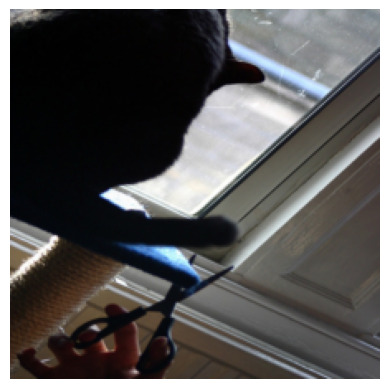

(Longest trained model) Generated caption: <bos>A man riding a skateboard down a ramp.<eos>
(Best test loss model) Generated caption: <bos> SM mossywalkTeddybear bank mottled clcok together hanFFEE strapped 18 mealRODBLACK frisby watch pimp dribbles Atlas dalm camouflage Francisco SWEATER barbec bundt tourbus wrapCrowd spikedSep hyr magazACHuminum forehead
(Best BLEU model) Generated caption: <bos>A man riding a skateboard on a wave.<eos>
(Best METEOR model) Generated caption: <bos>A man standing on a bench with a large umbrella.<eos>


In [ ]:
device = "cpu"
transformer.eval()
transformer_best_state.eval()
transformer_best_bleu.eval()
transformer_best_meteor.eval()

batch = next(iter(train_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu()
img = denormalize(img)
img = img.clamp(0, 1)
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=False)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
# print('Generated token ids:', tokens)
# print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('(Longest trained model) Generated caption:', decoded_caption)

tokens = transformer_best_state.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=False)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best test loss model) Generated caption:', decoded_caption)

tokens = transformer_best_bleu.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=False)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best BLEU model) Generated caption:', decoded_caption)

tokens = transformer_best_meteor.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=False)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best METEOR model) Generated caption:', decoded_caption)

Caption GT:  Female tennis player about to hit the ball
Input image shape: torch.Size([1, 3, 224, 224])


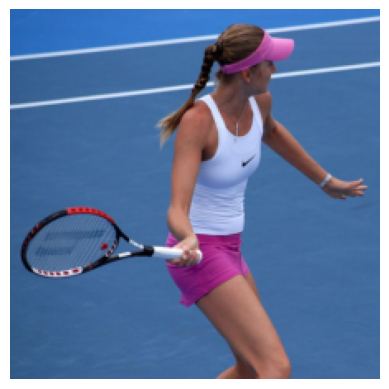

(Longest trained model) Generated caption: <bos>A woman on a tennis court swinging her racket.<eos>
(Best test loss model) Generated caption: <bos>A woman holding a tennis racquet on top of a court.<eos>
(Best BLEU model) Generated caption: <bos>A woman standing on top of a tennis court.<eos>
(Best METEOR model) Generated caption: <bos>A woman on a tennis court swinging her racket.<eos>


In [ ]:
batch = next(iter(test_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu()
img = denormalize(img)
img = img.clamp(0, 1)
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
# print('Generated token ids:', tokens)
# print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('(Longest trained model) Generated caption:', decoded_caption)

tokens = transformer_best_state.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best test loss model) Generated caption:', decoded_caption)

tokens = transformer_best_bleu.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best BLEU model) Generated caption:', decoded_caption)

tokens = transformer_best_meteor.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
decoded_caption = tokenizer.decode(tokens)
print('(Best METEOR model) Generated caption:', decoded_caption)

In [ ]:
# export training results to experiments directory
timestamp = time.strftime("%Y%m%d-%H%M%S")
dir = 'experiments/' + 'config_{}'.format(timestamp)
os.makedirs(dir, exist_ok=True)
results_path = os.path.join(dir, 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f)
# export config to results directory
config_path = os.path.join(dir, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f)

# export model weights
model_path = os.path.join(dir, f'cptr_model.pth')
torch.save(transformer.state_dict(), model_path)
best_loss_model_path = os.path.join(dir, f'cptr_best_loss_model.pth')
torch.save(best_model_test_state, best_loss_model_path)
best_bleu_model_path = os.path.join(dir, f'cptr_best_bleu_model.pth')
torch.save(best_model_bleu_state, best_bleu_model_path)
best_meteor_model_path = os.path.join(dir, f'cptr_best_meteor_model.pth')
torch.save(best_model_meteor_state, best_meteor_model_path)